# Emotion Detection of Twitter Data
## Dataset used:
### Sentiment140 dataset with 1.6 million tweets (Kaggle)

### Libraries

In [559]:
import pandas as pd
import numpy as np

import re
import preprocessor as p
import contractions
import unicodedata
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import gensim
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import langdetect

import matplotlib.pyplot as plt
import seaborn as sns

In [560]:
df = pd.read_csv("./Data/tweet_10k_2.csv", encoding="utf-8")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6913 entries, 0 to 6912
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    6913 non-null   object 
 1   query   6913 non-null   object 
 2   user    6913 non-null   object 
 3   label   5113 non-null   float64
 4   tweet   6911 non-null   object 
dtypes: float64(1), object(4)
memory usage: 270.2+ KB


,date,query,user,label,tweet
0,"Oct 13, 2023 · 11:59 PM UTC",#freepalestine,@ifusaysooo,1.0,"I'll make nice pics ,Free Palestine ,IsraeliWa..."
1,"Oct 18, 2023 · 9:53 PM UTC",#stophamas,@FreeIndepenent,1.0,Do you realize that Hamas organization charter...
2,"Oct 15, 2023 · 6:09 PM UTC",#indiastandswithpalestine,@IMMDUK,2.0,I have planted the flag of Palestine with the ...
3,"Oct 8, 2023 · 10:05 PM UTC",#stophamas,@OLifeshield,0.0,DIRECT IMPACTS reported in Ashkelon just now -...
4,"Oct 26, 2023 · 11:31 PM UTC",#hamasterrorists,@VTownGotSmoke,1.0,For every one you see there are ten more you d...


In [561]:
df["tweet"] = df["tweet"].astype('str')
df1 = df[["tweet", "label"]]
df1.notnull().sum()

tweet    6913
label    5113
dtype: int64

In [562]:
df1 = df1.dropna(ignore_index=True)
df1["label"] = df1["label"].astype('int')

df1.notnull().sum()

tweet    5113
label    5113
dtype: int64

In [563]:
df1["label"].value_counts()

label
0    2368
2    1866
1     879
Name: count, dtype: int64

### Ignoring Neutral tweets for now

In [564]:
df1 = df1.query("label == 0 | label == 2")
df1 = df1.reset_index()
df1

,index,tweet,label
0,2,I have planted the flag of Palestine with the ...,2
1,3,DIRECT IMPACTS reported in Ashkelon just now -...,0
2,5,#StandWithIsrael,0
3,8,"We are against Hamas, not against the people o...",0
4,9,What Hamas did was terrorism but what Israel i...,2
...,...,...,...
4229,5104,A trained money can read from a script too. #I...,2
4230,5105,"Yes, #ISupportIsrael",0
4231,5110,#palastine #FreePalastine #ISupportPalestine #...,2
4232,5111,Iron Dome working in Israel #Israelunderatta...,0


### Seperate the input and output columns

In [565]:
# Dividing the input text data and the associated output sentiment vector
twts, y = df1["tweet"], df1["label"]

## Custom preprocessing

### 1. remove_special_words_chars function to clean the data (like removing #tags(Kepping the useful ones), @mentions, reserved words) <br>Then lowercasing the words and finally resolving the contractions.
### 2. Preprocessing the data by tokenizing, removing StopWords and Lemmatizing the words in each sentences

In [566]:
def remove_special_words_chars(sentence, special_hashtags):
    # Keep Special hashtags
    pattern = r"#(" + "|".join(special_hashtags) + r")"
    result = re.sub(pattern, r'\1', sentence)

    # Pattern for #tag, @mention, email, links
    pattern = r'#\w+|@\w+|\S+@\S+|http\S+|www.\S+|\S+\.\S+'
    result = re.sub(pattern, '', result)

    # Pattern for repeated character words
    result = re.sub(r'\b(\w)(\1)+\b', '', result)

    # Pattern to match special characters, excluding those commonly used in emojis and emoticons
    # pattern = r'[^\w\s\d\p{So}\p{Sc}]'
    # pattern = r"[^\w\s\d" + "".join([re.escape(c) for c in unicodedata.category("SoSc")]) + "]"
    # pattern = r'[^\w\s\d\u20A0-\u32FF\u1F000-\u1F6FF]'  # Symbols and currency signs
    pattern = r'[^a-zA-Z\s\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF]'

    result = re.sub(pattern, "", result)

    # Pattern for removing multiple spaces
    result = re.sub(r'\s+', ' ', result)
    
    return result

In [567]:
print(remove_special_words_chars("hello! @subhodip :) 😀😀😀 123 #jsdf #good abc@ddg.com askn@kn , www.ddg.com http://www.ddg.com https://www.dsfsd.com google.com https aaa hellooo aaaa bbb", ["jsdf", "good"]))

hello 😀😀😀 jsdf good hellooo 


In [568]:
def process_twts(twts):
    # applying tweet cleaning, then lowercasing and finally resolving contractions
    # removing special characters
    tags = ["israel", "palestine", "hamas", "israelunderattack", "hamasattack", "stophamas", "stopisrael", "freepalestine", "standwithisrael", "hamasterrorists", "standwithpalestine", "israelpalestinewar", "indiaiswithisrael", "indiastandswithisrael", "indiastandswithpalestine", "isupportisrael", "isupportpalestine"]
    cleaned_twts = twts.map(lambda txt: ''.join(char for char in contractions.fix(remove_special_words_chars(txt.lower(), tags)))) # look after contractions
    # Tokenizing each sentences
    tokenized_twts = cleaned_twts.map(word_tokenize)
    # Removing Stop Words from sentences
    # Lemmatizing words in text
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    lemmatiized_twts = tokenized_twts.map(lambda txt: [lemmatizer.lemmatize(word) for word in txt if word not in stop_words])
    # lemmatiized_twts = tokenized_twts.map(lambda txt: [word for word in txt if word not in stop_words])

    return lemmatiized_twts

# Processing data without removing stop words. This is for vectorization purpose
def process_twts_with_swords(twts):
    # applying tweet cleaning, then lowercasing and finally resolving contractions
    # removing special characters
    tags = ["israel", "palestine", "hamas", "israelunderattack", "hamasattack", "stophamas", "stopisrael", "freepalestine", "standwithisrael", "hamasterrorists", "standwithpalestine", "israelpalestinewar", "indiaiswithisrael", "indiastandswithisrael", "indiastandswithpalestine", "isupportisrael", "isupportpalestine"]
    cleaned_twts = twts.map(lambda txt: ''.join(char if char.isalpha() or char.isspace() else ' ' for char in contractions.fix(remove_special_words_chars(txt.lower(), tags))))
    # Tokenizing each sentences
    tokenized_twts = cleaned_twts.map(word_tokenize)
    # Lemmatizing words in text
    # lemmatizer = WordNetLemmatizer()
    # lemmatiized_twts = tokenized_twts.map(lambda txt: [lemmatizer.lemmatize(word) for word in txt])

    return tokenized_twts

In [569]:
print("Number of tweets: ", len(twts), len(y))
# Processing all tweets by tokenizing, removing Stopwords and Lemmatizing words
processed_twts = process_twts(twts)
processed_twts_with_swords = process_twts_with_swords(twts)

mask = processed_twts.apply(lambda text: len(text) != 0)
mask1 = processed_twts_with_swords.apply(lambda text: len(text) != 0)
processed_twts = processed_twts[mask]
processed_twts_with_swords = processed_twts_with_swords[mask1]
y = y[mask]
y1 = y[mask1]

print("Number of processed twets after removing empty arrays: ", len(processed_twts), len(y))
print("Number of processed twets with stopwords after removing empty arrays: ", len(processed_twts_with_swords), len(y1))

Number of tweets:  4234 4234


Number of processed twets after removing empty arrays:  4233 4233
Number of processed twets with stopwords after removing empty arrays:  4233 4233


### Checking the processed data

In [570]:
i = 101
print("Raw: ", twts[i])
print("Processed: ", processed_twts[i])
print("Processed with stopwords: ", processed_twts_with_swords[i])

Raw:  Polokwane, Limpopo Hundreds of citizens demonstrated in Solidarity with the people of #Palestine at Polokwane @CapricornFMNews The peoples of the world #StandWithPalestine @OnlinePalEng @OnlinePalEng
Processed:  ['polokwane', 'limpopo', 'hundred', 'citizen', 'demonstrated', 'solidarity', 'people', 'palestine', 'polokwane', 'people', 'world', 'standwithpalestine']
Processed with stopwords:  ['polokwane', 'limpopo', 'hundreds', 'of', 'citizens', 'demonstrated', 'in', 'solidarity', 'with', 'the', 'people', 'of', 'palestine', 'at', 'polokwane', 'the', 'peoples', 'of', 'the', 'world', 'standwithpalestine']


### Splitting the dataset

In [571]:
x_train, x_test, y_train, y_test = train_test_split(processed_twts, y, test_size=0.2, random_state=5)
x_train1, x_test1, y_train1, y_test1 = train_test_split(processed_twts_with_swords, y1, test_size=0.2, random_state=5)
print(x_train.shape, x_test.shape)
print(x_train1.shape, x_test1.shape)

(3386,) (847,)
(3386,) (847,)


## Vectorizing the dataset using Tf-Idf value according to train data

In [572]:
# This is just to pass by the tokenizing in TfidfVectorizer class
def tokeniz(token):
    return token

vectorizer_uni = TfidfVectorizer(tokenizer=tokeniz, lowercase=False)

x_train_vectorized_uni = vectorizer_uni.fit_transform(x_train)
x_test_vectorized_uni = vectorizer_uni.transform(x_test)

c:\Users\subho\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [573]:
print(x_train_vectorized_uni[:5].toarray())
print(x_train_vectorized_uni.shape)
print(vectorizer_uni.get_feature_names_out())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(3386, 6480)
['aam' 'aaron' 'aasmani' ... '🫡' '🫵🏼😂🔥🔥' '🫶🏻💕standwithpalestine']


## Logistic regression on TF-IDF vectorized data

In [574]:
logRegModel_uni = LogisticRegression(max_iter=1000)

In [575]:
logRegModel_uni.fit(x_train_vectorized_uni, y_train)

LogisticRegression(max_iter=1000)

In [576]:
y_pred_logReg_uni = logRegModel_uni.predict(x_test_vectorized_uni)
y_pred_logReg_uni_tr = logRegModel_uni.predict(x_train_vectorized_uni)

In [577]:
print(logRegModel_uni.predict(vectorizer_uni.transform(process_twts(pd.Series(["isupportisrael"])))))

[0]


In [578]:
print("Logistic regression using unigram report: \n", classification_report(y_test, y_pred_logReg_uni))
print("Logistic regression using unigram report on Train data: \n", classification_report(y_train, y_pred_logReg_uni_tr))

Logistic regression using unigram report: 
               precision    recall  f1-score   support

           0       0.83      0.92      0.87       457
           2       0.90      0.77      0.83       390

    accuracy                           0.85       847
   macro avg       0.86      0.85      0.85       847
weighted avg       0.86      0.85      0.85       847

Logistic regression using unigram report on Train data: 
               precision    recall  f1-score   support

           0       0.90      0.95      0.92      1910
           2       0.93      0.86      0.89      1476

    accuracy                           0.91      3386
   macro avg       0.91      0.91      0.91      3386
weighted avg       0.91      0.91      0.91      3386



In [579]:
print(confusion_matrix(y_test, y_pred_logReg_uni))

[[422  35]
 [ 88 302]]


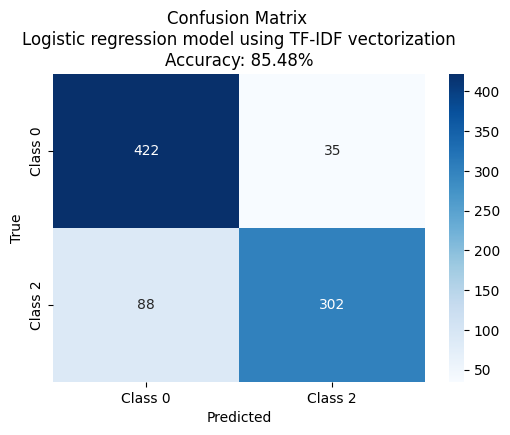

In [580]:
conf_mat_LR_uni = confusion_matrix(y_test, y_pred_logReg_uni)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat_LR_uni, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 2'], 
            yticklabels=['Class 0', 'Class 2'])

plt.title(f'Confusion Matrix \nLogistic regression model using TF-IDF vectorization\nAccuracy: {accuracy_score(y_test, y_pred_logReg_uni)*100:.2f}%')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [581]:
print(logRegModel_uni.predict(vectorizer_uni.transform(process_twts(pd.Series(["Palestinian authorities call on Hamas to release hostages — ambassador to Russia #News #Geopolitical #IsraelPalestineConflict #IsraelPalestineWar https://tass.com/politics/1691679"])))))

[0]


## Word2Vec model

In [582]:
w2v = Word2Vec(processed_twts, vector_size = 100, min_count=3)

### Train not required if own model

In [583]:
w2v.train(processed_twts, total_examples=len(processed_twts), epochs=20)

(590236, 863880)

In [584]:
print(w2v.wv.index_to_key)

['israel', 'hamas', 'palestine', 'freepalestine', 'israelunderattack', 'standwithisrael', 'people', 'gaza', 'terrorist', 'indiastandswithisrael', 'palestinian', 'israeli', 'isupportisrael', 'hamasterrorists', 'israelpalestinewar', 'standwithpalestine', 'indiastandswithpalestine', 'stophamas', 'isupportpalestine', 'support', 'stand', 'war', 'world', 'child', 'hamasattack', 'stopisrael', 'stop', 'hamasisisis', 'one', 'innocent', 'u', 'civilian', 'india', 'right', 'like', 'attack', 'israelpalestineconflict', 'must', 'time', 'killed', 'know', 'country', 'need', 'jew', 'state', 'terrorism', 'hamasmassacre', 'hospital', 'muslim', 'say', 'family', 'indiaiswithisrael', 'want', 'palestinegenocide', 'israelfightsback', 'peace', 'woman', 'free', 'palestineunderattack', 'never', 'israelterrorists', 'hamasterrorist', 'see', 'israelattack', 'every', 'baby', 'hostage', 'would', 'killing', 'israelterorrist', 'get', 'terror', 'even', 'genocide', 'always', 'take', 'crime', 'hamasisis', 'life', 'day', 'e

## Vectorizing train and test data

In [585]:
def wordvec(word, w2v):
    return w2v.wv[word] if word in w2v.wv.index_to_key else np.zeros(w2v.vector_size, dtype="float32")

# function accepting list of tokens and returning wordvector of the whole list
def vectorize(text, w2v):
    vectors = [wordvec(word, w2v) for word in text]

    return np.mean(vectors, axis=0)

In [586]:
x_train_vec = x_train.apply(lambda text: vectorize(text, w2v))
x_test_vec = x_test.apply(lambda text: vectorize(text, w2v))

In [587]:
# changing format Series to array
x_train_vec = np.stack(x_train_vec)
x_test_vec = np.stack(x_test_vec)

## Modelling on vectorized Document

In [588]:
logRegModel = LogisticRegression(max_iter=1000)
logRegModel.fit(x_train_vec, y_train)

LogisticRegression(max_iter=1000)

In [589]:
RFModel = RandomForestClassifier(n_estimators=100, criterion='gini', random_state=10)
RFModel.fit(x_train_vec, y_train)

RandomForestClassifier(random_state=10)

### Finding the best C value for SVM

In [590]:
def grid_search_c(c_max=50):
    best_accuracy = 0
    best_C = None
    best_model = None
    acc_test_li = []
    acc_train_li = []

    for c in range(10, c_max):
        # this part is to run the loop from 0.1 to 0.9
        if c <= 10:
            c /= 10
        else:
            c -= 9
            
        svmModel = svm.SVC(C=c, kernel='linear')
        svmModel.fit(x_train_vec, y_train)

        y_pred_svm = svmModel.predict(x_test_vec)
        y_pred_svm_tr = svmModel.predict(x_train_vec)

        acc_test = accuracy_score(y_test, y_pred_svm)
        acc_train = accuracy_score(y_train, y_pred_svm_tr)
        acc_test_li.append(acc_test)
        acc_train_li.append(acc_train)

        print(f"C = {c}, Test Accuracy: {acc_test}, \tTrain Accuracy: {acc_train} \t|Done...")
        if acc_test > best_accuracy:
            best_accuracy = acc_test
            best_C = c
            best_model = svmModel

    return best_model, best_C, best_accuracy, acc_test_li, acc_train_li

In [591]:
c_max = 60
c_values = []
for c in range(10, c_max):
        # this part is to run the loop from 0.1 to 0.9
        if c <= 10:
            c /= 10
        else:
            c -= 10
        c_values.append(float(c))

svmModel, c_value, svmAcc, acc_test, acc_train = grid_search_c(c_max)

C = 1.0, Test Accuracy: 0.8524203069657615, 	Train Accuracy: 0.8425871234494979 	|Done...
C = 2, Test Accuracy: 0.8500590318772137, 	Train Accuracy: 0.8431777909037212 	|Done...
C = 3, Test Accuracy: 0.8488783943329398, 	Train Accuracy: 0.8428824571766096 	|Done...
C = 4, Test Accuracy: 0.8500590318772137, 	Train Accuracy: 0.8437684583579445 	|Done...
C = 5, Test Accuracy: 0.8536009445100354, 	Train Accuracy: 0.8455404607206143 	|Done...
C = 6, Test Accuracy: 0.8524203069657615, 	Train Accuracy: 0.8461311281748376 	|Done...
C = 7, Test Accuracy: 0.8524203069657615, 	Train Accuracy: 0.8461311281748376 	|Done...
C = 8, Test Accuracy: 0.8488783943329398, 	Train Accuracy: 0.8473124630832841 	|Done...
C = 9, Test Accuracy: 0.8512396694214877, 	Train Accuracy: 0.8473124630832841 	|Done...
C = 10, Test Accuracy: 0.8536009445100354, 	Train Accuracy: 0.8473124630832841 	|Done...
C = 11, Test Accuracy: 0.8500590318772137, 	Train Accuracy: 0.8467217956290608 	|Done...
C = 12, Test Accuracy: 0.850

In [592]:
print("Best C value: ", c_value)
print("Best Accuracy: ", svmAcc)

Best C value:  40
Best Accuracy:  0.8618654073199528


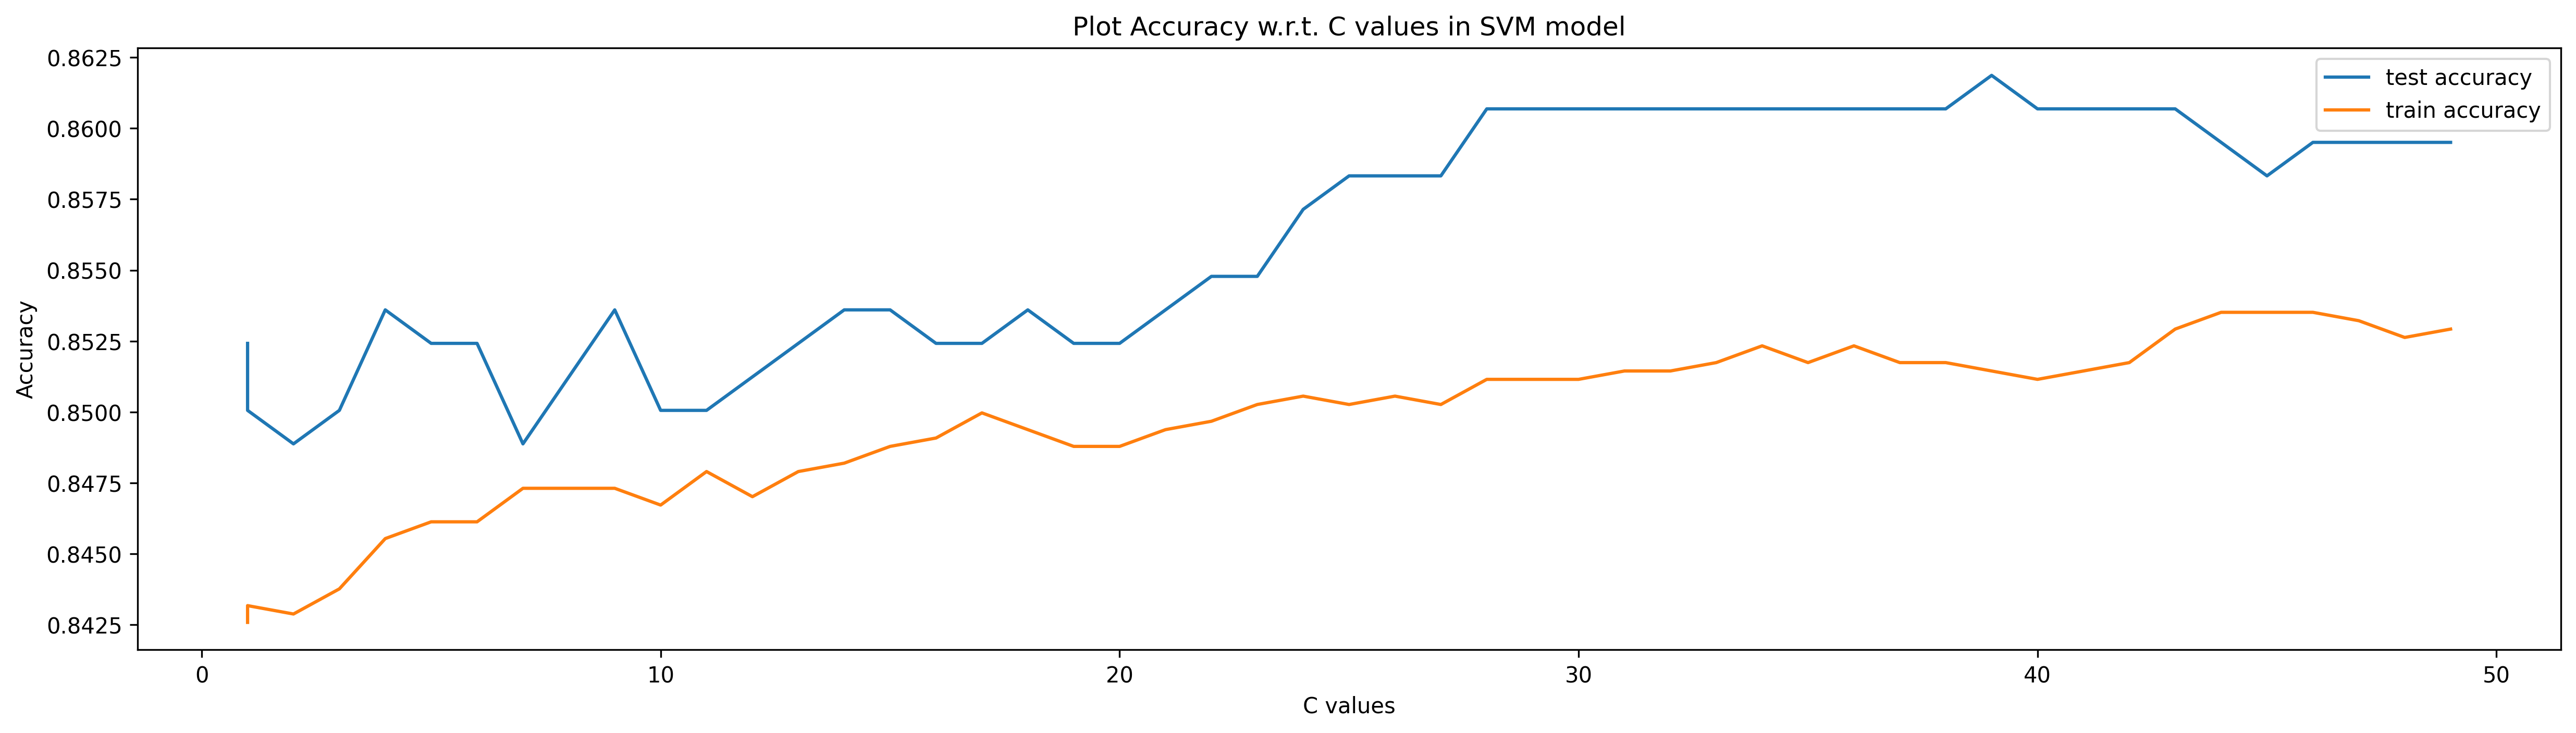

In [593]:
plt.figure(figsize=(20, 5), dpi=300)
plt.plot(c_values, acc_test, label="test accuracy")
plt.plot(c_values, acc_train, label="train accuracy")

plt.xlabel('C values')
plt.ylabel('Accuracy')
plt.title('Plot Accuracy w.r.t. C values in SVM model')
plt.legend()

plt.show()

In [594]:
y_pred_logReg = logRegModel.predict(x_test_vec)
y_pred_logReg_tr = logRegModel.predict(x_train_vec)
y_pred_RF = RFModel.predict(x_test_vec)
y_pred_RF_tr = RFModel.predict(x_train_vec)
y_pred_svm = svmModel.predict(x_test_vec)
y_pred_svm_tr = svmModel.predict(x_train_vec)

In [595]:
print("Logistic regression report: \n", classification_report(y_test, y_pred_logReg))
print("Logistic regression report on train data: \n", classification_report(y_train, y_pred_logReg_tr))
print("Random Forest report: \n", classification_report(y_test, y_pred_RF))
print("Random Forest report on train data: \n", classification_report(y_train, y_pred_RF_tr))
print("SVM using unigram report: \n", classification_report(y_test, y_pred_svm))
print("SVM using unigram report on train data: \n", classification_report(y_train, y_pred_svm_tr))

Logistic regression report: 
               precision    recall  f1-score   support

           0       0.82      0.93      0.87       457
           2       0.90      0.76      0.83       390

    accuracy                           0.85       847
   macro avg       0.86      0.85      0.85       847
weighted avg       0.86      0.85      0.85       847

Logistic regression report on train data: 
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      1910
           2       0.87      0.75      0.80      1476

    accuracy                           0.84      3386
   macro avg       0.85      0.83      0.84      3386
weighted avg       0.84      0.84      0.84      3386

Random Forest report: 
               precision    recall  f1-score   support

           0       0.83      0.89      0.86       457
           2       0.86      0.78      0.82       390

    accuracy                           0.84       847
   macro avg       0.85      0

In [596]:
conf_mat_LR = confusion_matrix(y_test, y_pred_logReg)
conf_mat_RF = confusion_matrix(y_test, y_pred_RF)
conf_mat_SVM = confusion_matrix(y_test, y_pred_svm)

print(confusion_matrix(y_test1, y_pred_logReg))
print(confusion_matrix(y_test1, y_pred_RF))
print(confusion_matrix(y_test1, y_pred_svm))

[[425  32]
 [ 92 298]]
[[409  48]
 [ 85 305]]
[[426  31]
 [ 86 304]]


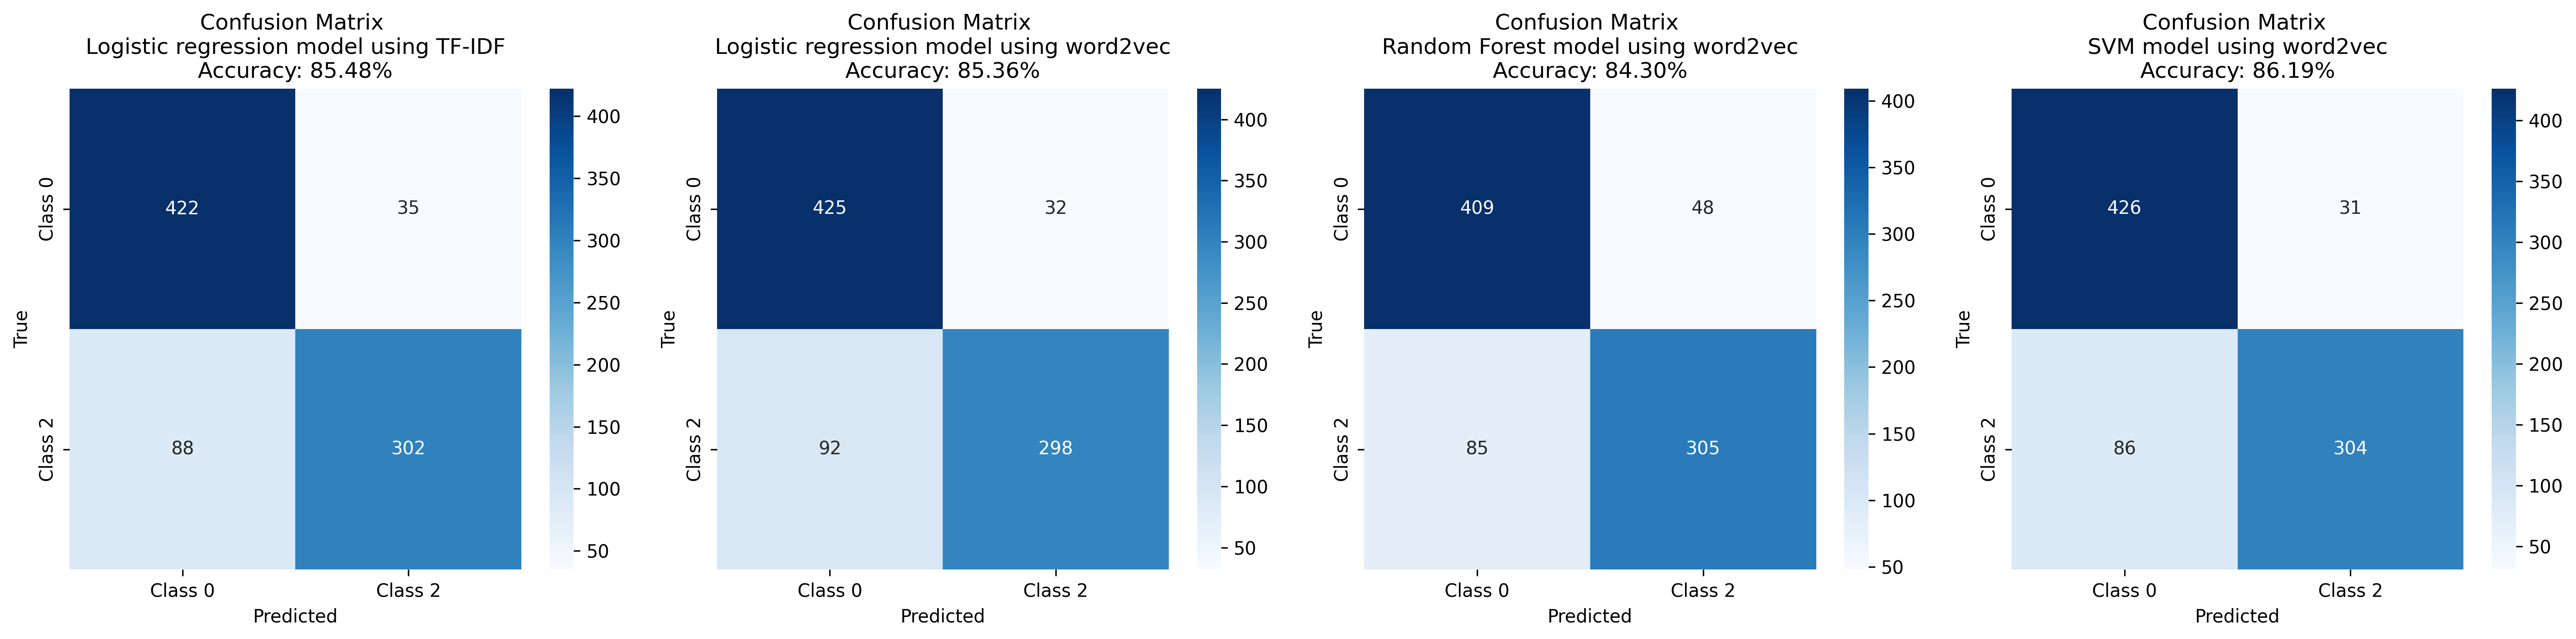

In [597]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5), dpi=300)

sns.heatmap(conf_mat_LR_uni, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 2'], 
            yticklabels=['Class 0', 'Class 2'],
            ax=axes[0])
axes[0].set_title(f'Confusion Matrix \nLogistic regression model using TF-IDF\nAccuracy: {accuracy_score(y_test, y_pred_logReg_uni)*100:.2f}%')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

sns.heatmap(conf_mat_LR, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 2'], 
            yticklabels=['Class 0', 'Class 2'],
            ax=axes[1])
axes[1].set_title(f'Confusion Matrix \nLogistic regression model using word2vec\nAccuracy: {accuracy_score(y_test, y_pred_logReg)*100:.2f}%')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

sns.heatmap(conf_mat_RF, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 2'], 
            yticklabels=['Class 0', 'Class 2'],
            ax=axes[2])
axes[2].set_title(f'Confusion Matrix \nRandom Forest model using word2vec\nAccuracy: {accuracy_score(y_test, y_pred_RF)*100:.2f}%')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')

sns.heatmap(conf_mat_SVM, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 2'], 
            yticklabels=['Class 0', 'Class 2'],
            ax=axes[3])
axes[3].set_title(f'Confusion Matrix \nSVM model using word2vec\nAccuracy: {accuracy_score(y_test, y_pred_svm)*100:.2f}%')
axes[3].set_xlabel('Predicted')
axes[3].set_ylabel('True')

plt.tight_layout()
plt.show()

In [614]:
from joblib import dump, load

filename = './models/svm_twitter_86_19.joblib'
dump(svmModel, filename)

# loaded_model = load(filename)

['./models/svm_twitter_86_19.joblib']

In [533]:
def predict_sentence(model, txt):
    return model.predict(np.stack(vectorize(process_twts(pd.Series(txt))[0], w2v)).reshape(1, -1))
def predict_sentences(model, txts):
    tmp = process_twts(pd.Series(txts))
    mask = tmp.apply(lambda text: len(text) != 0)
    tmp = tmp[mask]
    return model.predict(np.stack(tmp.apply(lambda txt: vectorize(txt, w2v))))

In [598]:
predict_sentence(svmModel, "God Bless him always 🕉🇮🇳🇬🇧🇲🇸🇫🇷🇦🇷💐💐🙏🙏#indiaiswithisrael")

array([0])

## Time series analysis of Israel-Hamas War

In [599]:
df_whole = pd.read_csv("./Data/data_v04.csv", encoding="utf-8")
df_whole["tweet"] = df_whole["tweet"].astype('str')

df_whole['date'] = pd.to_datetime(df_whole['date'], format="%b %d, %Y · %I:%M %p UTC")
df_whole.head()

,date,query,user,tweet
0,2023-10-07 23:59:00,#israel,@lindaloaiza24,Pidamos por la paz en #Israel. #LindaLoaiza
1,2023-10-07 23:59:00,#israel,@SSSE_LTD,https://whichuniversitys.com/london-police-pat...
2,2023-10-07 23:59:00,#israel,@Rohitdude_x,🙄😬😬 #IsraelUnderAttack #israel #Gaza #Hamas #...
3,2023-10-07 23:59:00,#israel,@life_travelled,Palestine & Pakistan are rogue entities; they ...
4,2023-10-07 23:59:00,#israel,@ArmanKirakosy12,The #Israeli army has announced that it has re...


In [602]:
# Sorting the whole data According to tweet date
df_sorted = df_whole.sort_values(by="date")
df_sorted.head(10)

,date,query,user,tweet
16748,2011-10-02 05:54:00,#freepalestine,@benshapiro,There should be no Palestinian state aside fro...
34310,2014-07-23 22:33:00,#israel,@MariamOssamaa,This is Gaza #ISupportIsrael #Israel #Israel...
34396,2014-07-23 22:35:00,#hamas,@MariamOssamaa,This is Gaza . #ISupportIsrael #Israel #Israe...
1238,2014-07-25 07:55:00,#isupportpalestine,@ImranKhanPTI,"My name is Imran Khan, I am from Pakistan and ..."
620,2015-01-18 11:13:00,#standwithisrael,@Luis_Delia,Muy buen domingo para tod@s
30079,2015-10-04 12:38:00,#isupportpalestine,@SubMedina,Palestinian journalist Hana Hammad continues w...
30406,2017-08-25 20:21:00,#stophamas,@Eye_On_Gaza,#GazaRevealed: Hamas bans personal meetings wi...
5716,2018-01-02 15:33:00,#hamasattack,@AlArabiya_Fa,سخنان حسن نصرالله درباره تامین همه هزینه‌های ح...
10545,2020-11-27 19:49:00,#indiastandswithisrael,@SachinKhunger,"Love this book, just read it again tonight. #M..."
24441,2021-05-12 03:37:00,#isupportisrael,@RaphMim,"I grew up in a Zionist household, spent 12 yea..."


In [603]:
# functio to detect language from list of words
def lang(txt):
    tmp = " ".join(txt)
    return langdetect.detect(tmp)

# function to return True for english Language
def only_english(row):
    try:
        if len(row) == 0:
            return False
        elif lang(row) == 'en':
            return True
        else:
         return False
    except Exception as e:
        print(f"Error processing row: {e}")
        return False
    # try:
    #     return lang(row) == 'en' if len(row) > 0 else False
    # except Exception as e:
    #     print(f"Error processing row: {e}")
    #     return False

In [604]:
# creating new dataframe of english language only
twts_processed = process_twts(df_sorted["tweet"])
df_eng = df_sorted[twts_processed.apply(only_english)]

Error processing row: No features in text.
Error processing row: No features in text.
Error processing row: No features in text.
Error processing row: No features in text.
Error processing row: No features in text.
Error processing row: No features in text.
Error processing row: No features in text.
Error processing row: No features in text.
Error processing row: No features in text.
Error processing row: No features in text.
Error processing row: No features in text.
Error processing row: No features in text.
Error processing row: No features in text.
Error processing row: No features in text.
Error processing row: No features in text.
Error processing row: No features in text.
Error processing row: No features in text.
Error processing row: No features in text.
Error processing row: No features in text.
Error processing row: No features in text.
Error processing row: No features in text.
Error processing row: No features in text.
Error processing row: No features in text.
Error proce

In [605]:
df_eng

,date,query,user,tweet
30079,2015-10-04 12:38:00,#isupportpalestine,@SubMedina,Palestinian journalist Hana Hammad continues w...
10545,2020-11-27 19:49:00,#indiastandswithisrael,@SachinKhunger,"Love this book, just read it again tonight. #M..."
24441,2021-05-12 03:37:00,#isupportisrael,@RaphMim,"I grew up in a Zionist household, spent 12 yea..."
33746,2021-05-12 03:37:00,#palestine,@RaphMim,"I grew up in a Zionist household, spent 12 yea..."
20040,2022-05-06 07:36:00,#stophamas,@FleurHassanN,Please take a moment to hear what these childr...
...,...,...,...,...
35091,2023-11-14 23:59:00,#freepalestine,@Tserendolg0r,"😂😂 it’s so ludicrous and funny, but also not f..."
35090,2023-11-14 23:59:00,#freepalestine,@kaydaddylor,and what about the 4000+ children in gaza that...
35089,2023-11-14 23:59:00,#freepalestine,@igogougogo58962,Zionist Boer from SA. Hamas will take of him.S...
34803,2023-11-14 23:59:00,#israel,@JustWaine22,Israel-Hamas Conflict: The Humanitarian Crisis...


In [606]:
print("All Tweets: ", len(twts_processed), "\nEnglish Tweets: ", len(df_eng))

All Tweets:  35312 
English Tweets:  23848


### Prediction on the whole dataset

In [612]:
start_date = pd.to_datetime("2023-10-07")  # Adjust as needed
interval_length = 3

# initializing israel and palestine support array
israel_support = []
palestine_support = []
date_interval = []

while start_date <= df_eng['date'].max():
    end_date = start_date + pd.DateOffset(days=interval_length - 1)

    # Select rows within the current interval
    df_interval = df_eng[(df_eng['date'] >= start_date) & (df_eng['date'] <= end_date)]
    twts = df_interval["tweet"]
    # print(df_interval)

    preds = predict_sentences(svmModel, twts)
    label, cnt = np.unique(preds, return_counts=True)

    israel_support.append(cnt[0])
    palestine_support.append(cnt[1])
    date_interval.append(start_date)

    # Move the start date to the next interval
    start_date += pd.DateOffset(days=interval_length)


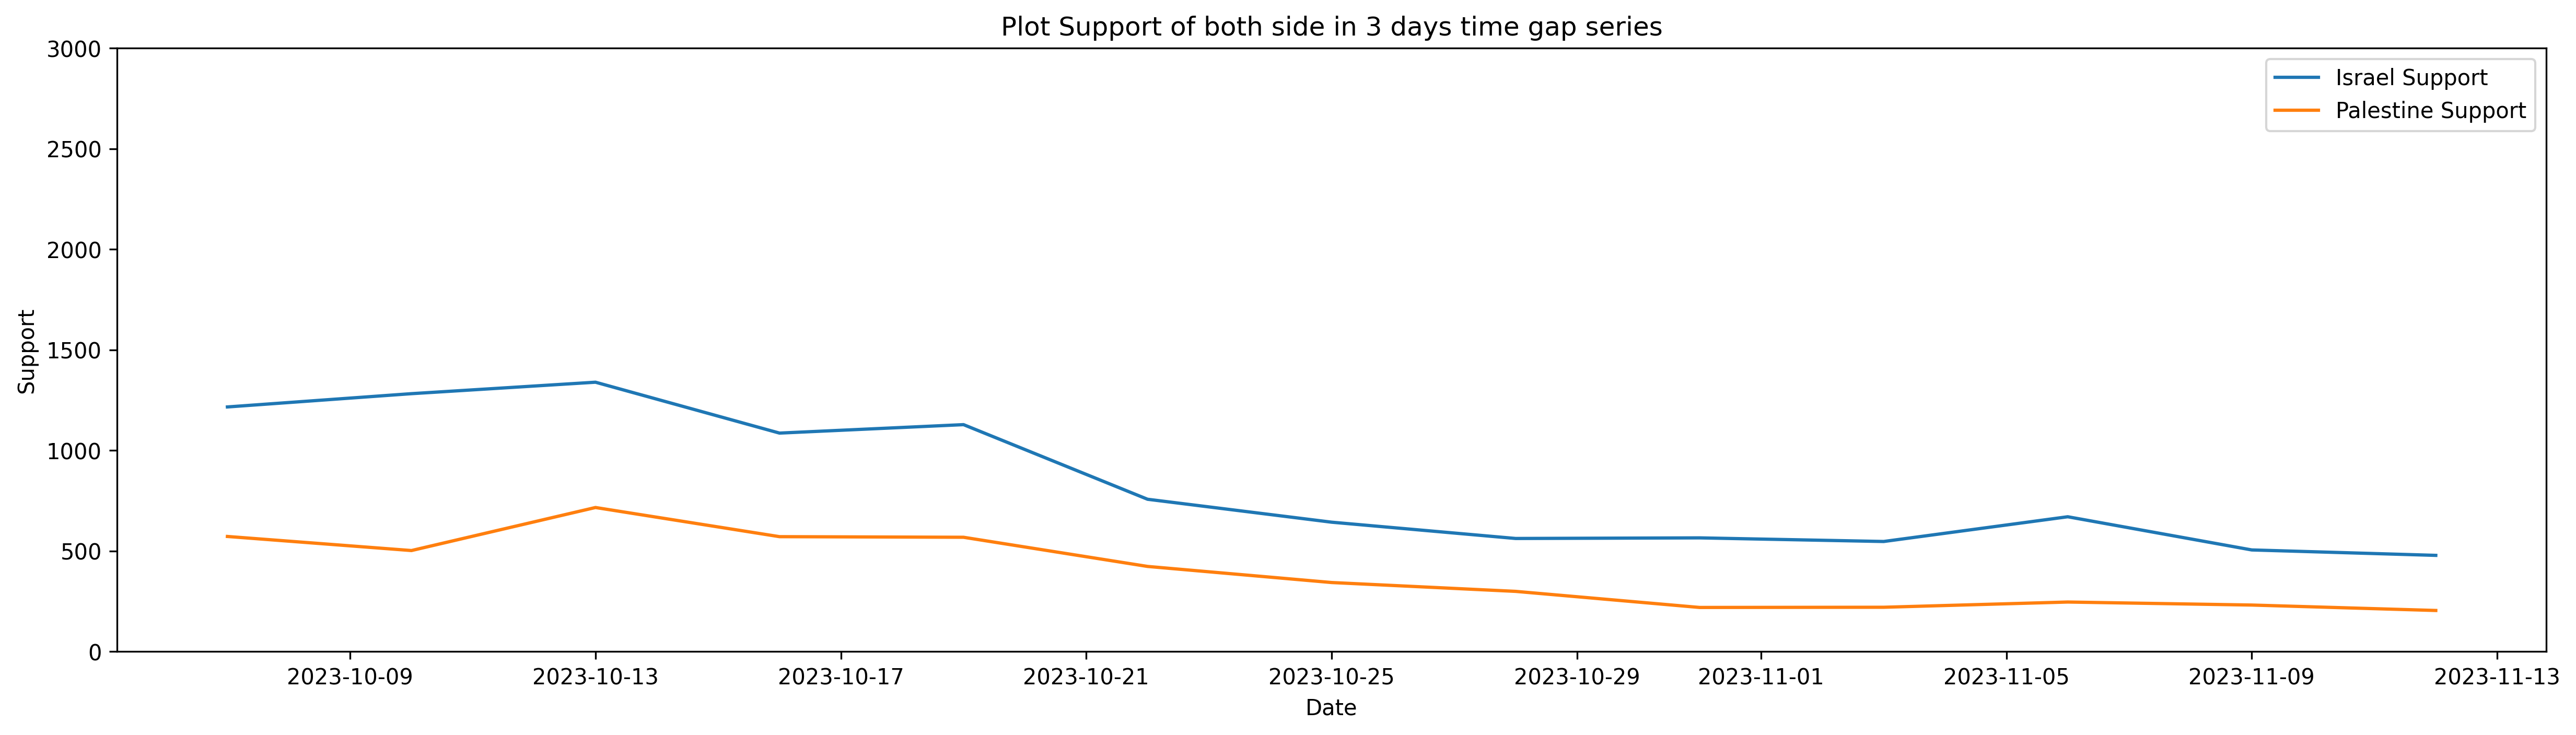

In [613]:
plt.figure(figsize=(20, 5), dpi=300)
plt.plot(date_interval, israel_support, label="Israel Support")
plt.plot(date_interval, palestine_support, label="Palestine Support")

plt.xlabel('Date')
plt.ylabel('Support')
plt.title(f'Plot Support of both side in {interval_length} days time gap series')
plt.legend()
plt.ylim(0, 3000)

plt.show()